# House Price Prediction — End-to-End
**Author:** JOHN EVANS OKYERE  
**Goal:** Predict `TARGET(PRICE_IN_LACS)` using OLS (LinearRegression), Ridge, and Lasso.  

**Notebook structure**
1. Environment & reproducibility
2. Load data
3. Quick sanity checks
4. Exploratory Data Analysis (EDA)
5. Feature engineering
6. Preprocessing and Pipelines
7. Model training (OLS, Ridge, Lasso) + hyperparameter tuning
8. Model evaluation & diagnostics
9. Final model, save, and prediction on test set
10. Conclusions & next steps


In [1]:
# Cell: 0 - Environment & reproducibility
import os, sys, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Python:", sys.version.splitlines()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)


Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:09:02) [GCC 11.2.0]
pandas: 2.3.3
numpy: 2.3.3
scikit-learn: 1.7.2


In [17]:
# Cell: 1 - Load data
TRAIN_PATH = "../datasets/raw/train.csv"  # path relative to notebook directory
TEST_PATH = "../datasets/raw/test.csv"

assert Path(TRAIN_PATH).exists(), f"train.csv not found at {TRAIN_PATH}"
assert Path(TEST_PATH).exists(), f"test.csv not found at {TEST_PATH}"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("train shape:", train.shape)
print("test shape:", test.shape)
train.head().T

train shape: (29451, 12)
test shape: (68720, 11)


,0,1,2,3,4
POSTED_BY,Owner,Dealer,Owner,Owner,Dealer
UNDER_CONSTRUCTION,0,0,0,0,1
RERA,0,0,0,1,0
BHK_NO.,2,2,2,2,2
BHK_OR_RK,BHK,BHK,BHK,BHK,BHK
SQUARE_FT,1300.236407,1275.0,933.159722,929.921143,999.009247
READY_TO_MOVE,1,1,1,1,0
RESALE,1,1,1,1,1
ADDRESS,"Ksfc Layout,Bangalore","Vishweshwara Nagar,Mysore","Jigani,Bangalore","Sector-1 Vaishali,Ghaziabad","New Town,Kolkata"
LONGITUDE,12.96991,12.274538,12.778033,28.6423,22.5922



## 2. Quick data sanity checks
Check column list, data types, missing values, duplicates. This helps form imputation decisions.


In [18]:
# Cell: 2 - Sanity checks
display(train.columns)
train.info()
print("\nMissing values (train):")
print(train.isnull().sum().sort_values(ascending=False).head(20))
print("\nDuplicates in train:", train.duplicated().sum())


Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB

Missing values (train):
POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                  

### Column meanings (for clarity)
- `POSTED_BY`: categorical — who listed (Owner, Dealer, etc.)
- `UNDER_CONSTRUCTION`, `RERA`, `READY_TO_MOVE`, `RESALE`: binary flags (0/1)
- `BHK_NO.`: numeric — number of bedrooms
- `BHK_OR_RK`: categorical — 'BHK' or 'RK'
- `SQUARE_FT`: numeric — area in square feet
- `ADDRESS`: text — locality; typically like "Locality,City"
- `LONGITUDE`, `LATITUDE`: float — coordinates
- `TARGET(PRICE_IN_LACS)`: numeric target in lakhs of rupees


## 3. Exploratory Data Analysis (EDA)
We will:
- Inspect target distribution (skewness)
- Check relationships with key numeric features
- Inspect categorical counts
- Look for outliers or bad values


Target summary:


count    29451.000000
mean       142.898746
std        656.880713
min          0.250000
25%         38.000000
50%         62.000000
75%        100.000000
max      30000.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

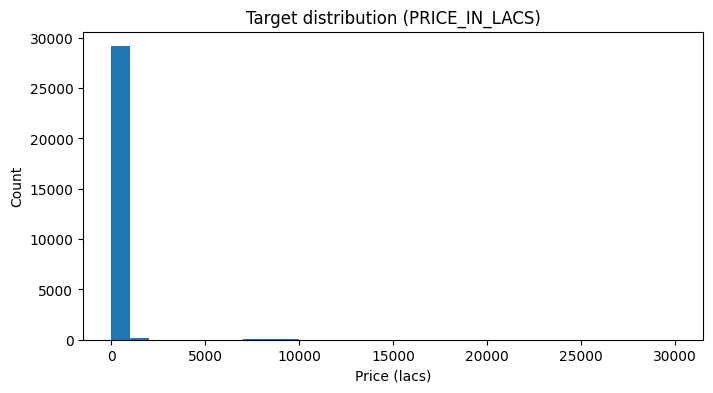

['UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'LONGITUDE',
 'LATITUDE',
 'TARGET(PRICE_IN_LACS)']

In [19]:
# Cell: 3 - EDA: target distribution + numeric summary
target_col = "TARGET(PRICE_IN_LACS)"
print("Target summary:")
display(train[target_col].describe())
plt.figure(figsize=(8,4))
plt.hist(train[target_col], bins=30)
plt.title("Target distribution (PRICE_IN_LACS)")
plt.xlabel("Price (lacs)")
plt.ylabel("Count")
plt.show()

# numeric features
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols


TARGET(PRICE_IN_LACS)    1.000000
SQUARE_FT                0.402685
BHK_NO.                  0.112283
LATITUDE                -0.017254
LONGITUDE               -0.031112
Name: TARGET(PRICE_IN_LACS), dtype: float64

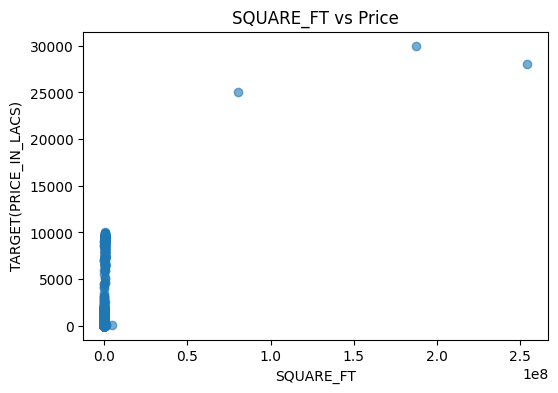

In [20]:
# Pair relationships for core numeric features
core = ['SQUARE_FT', 'BHK_NO.', 'LATITUDE', 'LONGITUDE', target_col]
display(train[core].corr()[target_col].sort_values(ascending=False))
plt.figure(figsize=(6,4))
plt.scatter(train['SQUARE_FT'], train[target_col], alpha=0.6)
plt.xlabel('SQUARE_FT'); plt.ylabel('TARGET(PRICE_IN_LACS)')
plt.title('SQUARE_FT vs Price')
plt.show()


In [21]:
# Categorical distributions
cat_cols = ['POSTED_BY', 'BHK_OR_RK', 'city' if 'city' in train.columns else 'ADDRESS']
for c in ['POSTED_BY','BHK_OR_RK']:
    if c in train.columns:
        print(f"\nValue counts for {c}:")
        display(train[c].value_counts().head(20))



Value counts for POSTED_BY:


POSTED_BY
Dealer     18291
Owner      10538
Builder      622
Name: count, dtype: int64


Value counts for BHK_OR_RK:


BHK_OR_RK
BHK    29427
RK        24
Name: count, dtype: int64

### POSTED_BY:

Interpretation:
The dataset is dominated by listings posted by Dealers (~62%), followed by Owners (~36%), and a very small number by Builders (~2%).

Implication:
    This is a categorical variable with 3 unique classes and moderate class imbalance.
    The imbalance isn’t extreme (less than 10× difference), so OneHotEncoding will handle it fine.
    However, the “Builder” category has very few samples, so the model might learn less reliable coefficients for that category.

### BHK OR RK:


Interpretation:
Almost all properties (≈99.9%) are BHK-type.
Only 24 records are “RK” (room-kitchen) type — this is extreme imbalance.

Implication:
BHK_OR_RK has negligible variance — in ML terms, it’s quasi-constant.

Keeping it might not help the model; in fact, it could introduce noise, since 24 samples are statistically irrelevant compared to 29K total.



## Solution to the categorical variables


In [22]:
train.groupby('POSTED_BY')['UNDER_CONSTRUCTION'].mean()


POSTED_BY
Builder    0.668810
Dealer     0.230441
Owner      0.062915
Name: UNDER_CONSTRUCTION, dtype: float64

In [ ]:
train_fe['POSTED_BY'] = train_fe['POSTED_BY'].replace({'Builder': 'Dealer/Builder'})


train_fe = train_fe.drop(columns=['BHK_OR_RK'])
test_fe = test_fe.drop(columns=['BHK_OR_RK'])


## 4. Feature Engineering
We'll:
- Parse `city` from `ADDRESS` (simple approach: last token after comma)
- Create `sqft_per_bhk` and `bhk_times_sqft` (do not use price-derived features)
- Create geospatial cluster (KMeans) to capture neighborhood effects
- Ensure the same transformations are applied to train & test using pipelines


In [23]:
# Cell: 4 - Feature engineering helpers and application
def parse_city(addr):
    if pd.isna(addr): return "unknown"
    parts = [p.strip() for p in str(addr).split(',') if p.strip()]
    if len(parts)==0: return "unknown"
    return parts[-1].lower()

train_fe = train.copy()
test_fe = test.copy()

# parse city (if ADDRESS exists)
if 'ADDRESS' in train_fe.columns:
    train_fe['city'] = train_fe['ADDRESS'].apply(parse_city)
if 'ADDRESS' in test_fe.columns:
    test_fe['city'] = test_fe['ADDRESS'].apply(parse_city)

# simple engineered numeric features (no leakage)
train_fe['sqft_per_bhk'] = train_fe['SQUARE_FT'] / train_fe['BHK_NO.'].replace(0, np.nan)
train_fe['bhk_times_sqft'] = train_fe['SQUARE_FT'] * train_fe['BHK_NO.']

test_fe['sqft_per_bhk'] = test_fe['SQUARE_FT'] / test_fe['BHK_NO.'].replace(0, np.nan)
test_fe['bhk_times_sqft'] = test_fe['SQUARE_FT'] * test_fe['BHK_NO.']

# quick look
train_fe[['SQUARE_FT','BHK_NO.','sqft_per_bhk','bhk_times_sqft','city']].head()


,SQUARE_FT,BHK_NO.,sqft_per_bhk,bhk_times_sqft,city
0,1300.236407,2,650.118204,2600.472814,bangalore
1,1275.000000,2,637.500000,2550.000000,mysore
2,933.159722,2,466.579861,1866.319444,bangalore
3,929.921143,2,464.960571,1859.842285,ghaziabad
4,999.009247,2,499.504623,1998.018494,kolkata


### 4.1 Geospatial clustering
Clustering coordinates into discrete neighborhood buckets often helps linear models capture locality effects. We'll fit KMeans on training coordinates and predict cluster labels for test.


In [24]:
# Cell: 4.1 - Geospatial clustering
from sklearn.cluster import KMeans

if {'LATITUDE','LONGITUDE'}.issubset(train_fe.columns):
    coords = train_fe[['LATITUDE','LONGITUDE']].dropna()
    # pick k based on dataset size - start with 20 (tune if needed)
    K = 20 if len(train_fe) > 500 else max(5, int(len(train_fe)/50))
    kmeans = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
    # fit on rows with non-null coords
    non_null_coords = train_fe[['LATITUDE','LONGITUDE']].fillna(0)
    kmeans.fit(non_null_coords)
    train_fe['geo_cluster'] = kmeans.predict(non_null_coords)
    if {'LATITUDE','LONGITUDE'}.issubset(test_fe.columns):
        test_fe['geo_cluster'] = kmeans.predict(test_fe[['LATITUDE','LONGITUDE']].fillna(0))
else:
    # fallback: set single cluster
    train_fe['geo_cluster'] = 0
    test_fe['geo_cluster'] = 0

train_fe[['LATITUDE','LONGITUDE','geo_cluster']].head()


,LATITUDE,LONGITUDE,geo_cluster
0,77.597960,12.969910,4
1,76.644605,12.274538,4
2,77.632191,12.778033,4
3,77.344500,28.642300,0
4,88.484911,22.592200,3


## 5. Preprocessing plan & Pipelines
**Principles**
- Use `ColumnTransformer` to apply appropriate transforms per column group.
- Numeric: median imputation + StandardScaler
- Binary: impute with mode (most frequent)
- Categorical: impute 'missing' + OneHotEncoder(handle_unknown='ignore')
- Wrap preprocessing + estimator in a `Pipeline` to avoid leakage


In [25]:
train_fe.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),city,sqft_per_bhk,bhk_times_sqft,geo_cluster
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,bangalore,650.118204,2600.472814,4
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,mysore,637.500000,2550.000000,4
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,bangalore,466.579861,1866.319444,4
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,ghaziabad,464.960571,1859.842285,0
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,kolkata,499.504623,1998.018494,3


In [26]:
# Cell: 5 - Define preprocessing pipeline components
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Merge Dealer and Builder into one column name
train_fe['POSTED_BY'] = train_fe['POSTED_BY'].replace({'Builder': 'Dealer/Builder'})


train_fe = train_fe.drop(columns=['BHK_OR_RK'])
test_fe = test_fe.drop(columns=['BHK_OR_RK'])


# Define feature groups (ensure they exist)
numeric_features = [c for c in ['SQUARE_FT','BHK_NO.','sqft_per_bhk','bhk_times_sqft','LATITUDE','LONGITUDE'] if c in train_fe.columns]
binary_features = [c for c in ['UNDER_CONSTRUCTION','RERA','READY_TO_MOVE','RESALE'] if c in train_fe.columns]
categorical_features = [c for c in ['POSTED_BY','BHK_OR_RK','city','geo_cluster'] if c in train_fe.columns]

print("numeric:", numeric_features)
print("binary:", binary_features)
print("categorical:", categorical_features)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # binary flags typically don't need scaling but could be cast to int
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('bin', binary_transformer, binary_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')


numeric: ['SQUARE_FT', 'BHK_NO.', 'sqft_per_bhk', 'bhk_times_sqft', 'LATITUDE', 'LONGITUDE']
binary: ['UNDER_CONSTRUCTION', 'RERA', 'READY_TO_MOVE', 'RESALE']
categorical: ['POSTED_BY', 'city', 'geo_cluster']


## 6. Modeling — OLS, Ridge, Lasso
We will:
- Split training data into train/validation
- Build Pipelines:
  - preprocessor + LinearRegression
  - preprocessor + Ridge
  - preprocessor + Lasso
- Use cross-validation and GridSearchCV to tune `alpha` for Ridge and Lasso.


In [27]:
# Cell: 6 - Train/validation split and pipeline definitions
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare X and y
target_col = "TARGET(PRICE_IN_LACS)"
assert target_col in train_fe.columns, f"{target_col} not found in train"

X = train_fe.drop(columns=[target_col, 'ADDRESS'] if 'ADDRESS' in train_fe.columns else [target_col])
y = train_fe[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("X_train:", X_train.shape, "X_val:", X_val.shape)

pipe_ols = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipe_ridge = Pipeline([('preprocessor', preprocessor), ('regressor', Ridge(random_state=RANDOM_STATE))])
pipe_lasso = Pipeline([('preprocessor', preprocessor), ('regressor', Lasso(random_state=RANDOM_STATE, max_iter=10000))])


X_train: (23560, 13) X_val: (5891, 13)


In [28]:
# Cell: 6.1 - Quick cross-validation baseline (no tuning)
scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
for name, pipe in [('OLS', pipe_ols), ('Ridge', pipe_ridge), ('Lasso', pipe_lasso)]:
    cv_results = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    print(f"{name}: RMSE={-np.mean(cv_results['test_neg_root_mean_squared_error']):.4f}, R2={np.mean(cv_results['test_r2']):.4f}, MAE={-np.mean(cv_results['test_neg_mean_absolute_error']):.4f}")


OLS: RMSE=28366.1227, R2=-7830.2450, MAE=533.3173
Ridge: RMSE=28273.3270, R2=-7796.0657, MAE=534.8965
Ridge: RMSE=28273.3270, R2=-7796.0657, MAE=534.8965
Lasso: RMSE=27807.4574, R2=-7535.9349, MAE=523.1605
Lasso: RMSE=27807.4574, R2=-7535.9349, MAE=523.1605


In [29]:
# Cell: 6.2 - Hyperparameter tuning for Ridge and Lasso
param_grid_ridge = {'regressor__alpha': np.logspace(-3, 3, 13)}
param_grid_lasso = {'regressor__alpha': np.logspace(-4, 1, 13)}

ridge_cv = GridSearchCV(pipe_ridge, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_cv = GridSearchCV(pipe_lasso, param_grid_lasso, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print("Fitting Ridge CV ...")
ridge_cv.fit(X_train, y_train)
print("Ridge best alpha:", ridge_cv.best_params_, "best RMSE:", -ridge_cv.best_score_)

print("Fitting Lasso CV ...")
lasso_cv.fit(X_train, y_train)
print("Lasso best alpha:", lasso_cv.best_params_, "best RMSE:", -lasso_cv.best_score_)


Fitting Ridge CV ...
Ridge best alpha: {'regressor__alpha': np.float64(1000.0)} best RMSE: 26679.784942590202
Fitting Lasso CV ...
Ridge best alpha: {'regressor__alpha': np.float64(1000.0)} best RMSE: 26679.784942590202
Fitting Lasso CV ...


/home/grejoy/Projects/House_Price_Prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.029e+09, tolerance: 7.575e+05
  model = cd_fast.enet_coordinate_descent(
/home/grejoy/Projects/House_Price_Prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+09, tolerance: 7.451e+05
  model = cd_fast.enet_coordinate_descent(
/home/grejoy/Projects/House_Price_Prediction/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

Lasso best alpha: {'regressor__alpha': np.float64(10.0)} best RMSE: 26833.653148765774


## 7. Evaluate on validation set
Evaluate OLS (fit on training split), best Ridge, best Lasso on hold-out validation set using RMSE, MAE, R².


In [ ]:
# Cell: 7 - Fit OLS and evaluate all models on validation set
pipe_ols.fit(X_train, y_train)

models = {
    'OLS': pipe_ols,
    'Ridge': ridge_cv.best_estimator_,
    'Lasso': lasso_cv.best_estimator_
}

results = {}
for name, model in models.items():
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))  # changed here
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2}
    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")


TypeError: got an unexpected keyword argument 'squared'